In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

In [3]:
import os
import zipfile

In [4]:
import seaborn as sns

In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:
df_train = pd.read_csv('Corona_NLP_train.csv',
                        encoding='latin_1')
test_data = pd.read_csv("Corona_NLP_test.csv",encoding='latin_1')

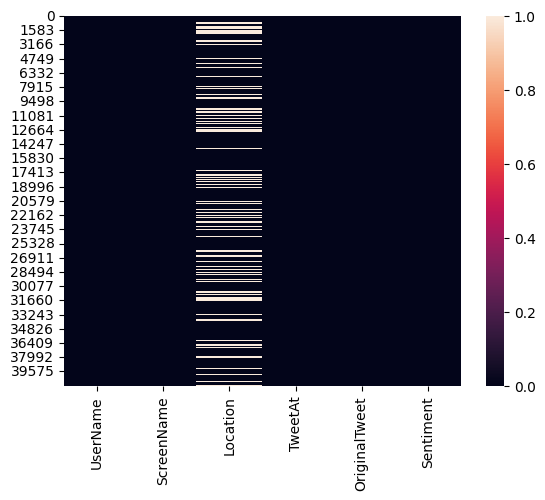

In [7]:
# check for null value in train_data
sns.heatmap(df_train.isnull());

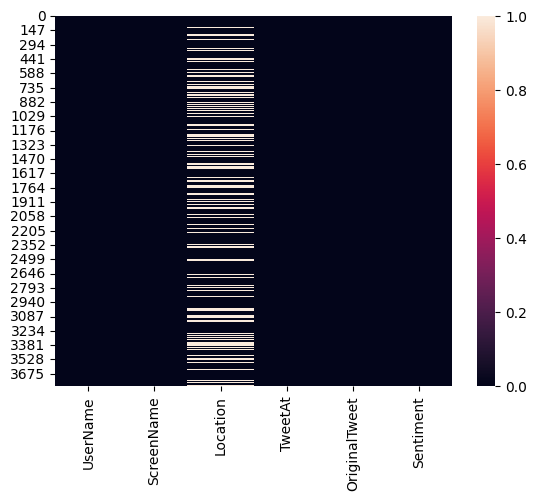

In [8]:
# check for null values in test data
sns.heatmap(test_data.isnull());

In [9]:
df_train.drop_duplicates(inplace= True)
test_data.drop_duplicates(inplace=True)

In [10]:
df_train.dropna(inplace=True)
test_data.dropna(inplace=True)

In [11]:
# copy the dataset into new data
df_train = df_train.copy()
test_df = test_data.copy()

In [12]:
print(df_train.isnull().sum())
print("*"*50)
print(test_df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
**************************************************
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


In [13]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})

In [14]:
df_train.shape, test_df.shape

((32567, 6), (2964, 6))

In [15]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

In [16]:
df_train['Sentiment'] = df_train['Sentiment'].apply(lambda x: change_sen(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: change_sen(x))

In [17]:
# load stop words
stop_word = stopwords.words('english')

In [18]:
def clean(text):

    #     remove urls
    text = re.sub(r'http\S+', " ", text)

    #     remove mentions
    text = re.sub(r'@\w+',' ',text)

    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)

    #     remove digits
    text = re.sub(r'\d+', ' ', text)

    #     remove html tags
    text = re.sub('r<.*?>',' ', text)
    
    #     remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
    
      
    return text

In [19]:
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lambda x: clean(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean(x))

In [20]:
df_train = df_train.iloc[:,4:]
df_test = test_df.iloc[:,4:]

In [21]:
df_train.head()

,OriginalTweet,Sentiment
0,,netural
1,advice Talk neighbours family exchange phone n...,positive
2,Coronavirus Australia: Woolworths give elderly...,positive
5,As news regionÂs first confirmed COVID- case ...,positive
6,Cashier grocery store sharing insights To prov...,positive


In [22]:
l = {"netural":0, "positive":1,"negative":2}

In [23]:
df_train['Sentiment'] = df_train['Sentiment'].map(l)
df_test['Sentiment']  = df_test['Sentiment'].map(l)

In [24]:
x_train = df_train['OriginalTweet'].copy()
x_test = df_test['OriginalTweet'].copy()

y_train = df_train['Sentiment'].copy()
y_test = df_test['Sentiment'].copy()

In [25]:
x_train.shape, y_train.shape,x_test.shape, y_test.shape

((32567,), (32567,), (2964,), (2964,))

In [26]:
max_len = np.max(x_train.apply(lambda x :len(x)))

In [27]:
tokenizer = Tokenizer()

In [28]:
tokenizer.fit_on_texts(x_train)
vocab_length = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

In [29]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_len)

Vocab length: 31759
Max sequence length: 286


In [30]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [31]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 286, 16)           508144    
                                                                 
 bidirectional (Bidirectiona  (None, 286, 512)         420864    
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

In [32]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [33]:
pip install pydot

  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
Note: you may need to restart the kernel to use updated packages.


In [34]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((32567, 286), (2964, 286), (32567,), (2964,))

In [35]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [36]:
num_epochs = 10
history = model.fit(x_train, y_train, epochs=num_epochs, 
                    validation_data=(x_test, y_test))

Epoch 1/10


2023-03-29 15:39:48.808381: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1018/1018 [==============================] - 387s 379ms/step - loss: 0.9518 - accuracy: 0.5266 - val_loss: 0.7566 - val_accuracy: 0.6727
Epoch 2/10
1018/1018 [==============================] - 302s 296ms/step - loss: 0.6000 - accuracy: 0.7791 - val_loss: 0.4814 - val_accuracy: 0.8225
Epoch 3/10
1018/1018 [==============================] - 287s 282ms/step - loss: 0.3810 - accuracy: 0.8850 - val_loss: 0.4598 - val_accuracy: 0.8455
Epoch 4/10
1018/1018 [==============================] - 302s 297ms/step - loss: 0.2853 - accuracy: 0.9181 - val_loss: 0.5075 - val_accuracy: 0.8387
Epoch 5/10
1018/1018 [==============================] - 363s 357ms/step - loss: 0.2222 - accuracy: 0.9366 - val_loss: 0.5310 - val_accuracy: 0.8354
Epoch 6/10
1018/1018 [==============================] - 584s 574ms/step - loss: 0.1767 - accuracy: 0.9474 - val_loss: 0.6349 - val_accuracy: 0.8340
Epoch 7/10
1018/1018 [==============================] - 301s 295ms/step - loss: 0.1540 - accuracy: 0.9525 - val_loss: 0.668

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [38]:
print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

Accuracy on training data is:- 96.90484404563904 %
Loss 10.100574791431427
Accuracy on validation data is:- 81.78137540817261 %
Loss 83.73557925224304


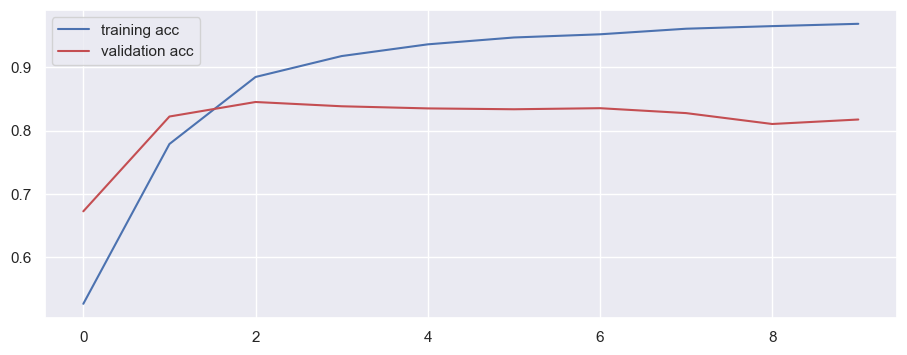

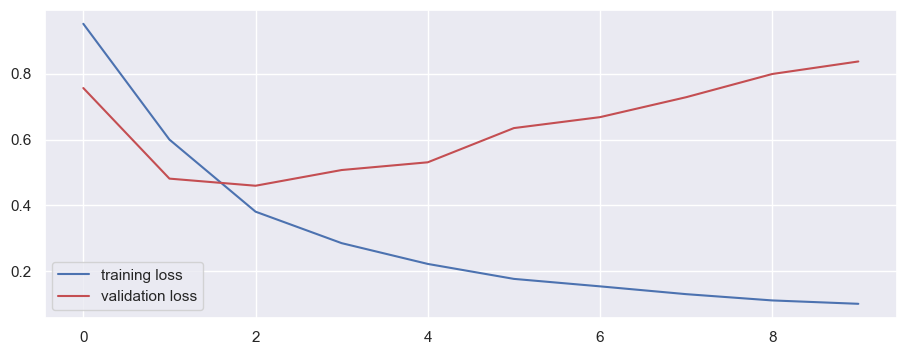

In [39]:
epochs = range(len(acc))

plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.legend()
plt.show()


plt.plot(epochs, loss,'b',label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

In [50]:
pred = np.argmax(model.predict(x_test), axis=-1)

93/93 [==============================] - 8s 82ms/step


In [51]:
print(classification_report(np.argmax(y_test,1),pred))

              precision    recall  f1-score   support

           0       0.68      0.80      0.74       497
           1       0.85      0.81      0.83      1207
           2       0.86      0.83      0.84      1260

    accuracy                           0.82      2964
   macro avg       0.79      0.82      0.80      2964
weighted avg       0.82      0.82      0.82      2964

